<a href="https://colab.research.google.com/github/mejrihaifa/ionicapp/blob/main/Mini_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tensorflow-gpu==2.2.0
# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.1.0'

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.3 MB 4.0 kB/s 
     |████████████████████████████████| 3.0 MB 48.9 MB/s 
     |████████████████████████████████| 2.9 MB 48.6 MB/s 
     |████████████████████████████████| 26.0 MB 1.4 MB/s 
     |████████████████████████████████| 454 kB 64.4 MB/s 
     |████████████████████████████████| 152 kB 53.4 MB/s 
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.2.0
    Uninstalling cachetools-5.2.0:
      Successfully uninstalled cachetools-5.2.0
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.15.0
    Uninstalling google-auth-2.15.0:
      Successfully uninstalled google-auth-2.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [ ]:
import os
#Load data
zip_file=tf.keras.utils.get_file(origin='https://mega.nz/file/5xpGyaYB#lhvcxkPmvKAIiGy0mh4HYKgynbCEOVDkinvgmstXOGk', 
 fname='DDSMROI.zip', extract=True)
#Create the training and validation directories
data_dir = os.path.join(os.path.dirname(zip_file), 'DDSMROI')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
#validation_dir = os.path.join(os.path.dirname(zip_file), 'DDSM')
print(validation_dir)

import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

/root/.keras/datasets/DDSMROI/validation
/content
total images for training : /root/.keras/datasets/DDSMROI/train : 0files
total images for validation : /root/.keras/datasets/DDSMROI/validation : 0files


In [ ]:
#!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
#!unzip master.zip;
#import json
#with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
#    cat_to_name = json.load(f)
#    classes = list(cat_to_name.values())
    
#print (classes)
classes = []
classes.append("Begnin")
classes.append("Malignant")
classes.append("Normal")

print (classes)


['Begnin', 'Malignant', 'Normal']


In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2".format(handle_base) #@param {type:"string"}
#"https://tfhub.dev/google/tf2- preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 64 #@param {type:"integer"}


In [ ]:
# Inputs are suitably resized for the selected module.
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.2, # randomly zoom into images
     rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
     horizontal_flip=False,  # randomly flip images
     vertical_flip=False  # randomly flip images
     )


#history.model.save('my_model3.h5')
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    directory=r"./malignant/",
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    directory=r"./malignant/",
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 209 images belonging to 3 classes.
Found 209 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
    feature_extractor.trainable = True
    # unfreeze some layers of base network for fine-tuning
    for layer in feature_extractor.layers[-30:]:
       layer.trainable =True
  
else:
    feature_extractor.trainable = False

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [ ]:
#Compile model specifying the optimizer learning rate
LEARNING_RATE = 0.001 #@param {type:"number"}
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
EPOCHS=10 #@param {type:"integer"}
STEPS_EPOCHS = train_generator.samples//train_generator.batch_size
VALID_STEPS=validation_generator.samples//validation_generator.batch_size
history = model.fit_generator( 
          train_generator,
          steps_per_epoch=STEPS_EPOCHS,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=VALID_STEPS)

<ipython-input-71-10fd4aaab187>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
3/3 [==============================] - 98s 38s/step - loss: 0.3763 - accuracy: 0.7917 - val_loss: 5.8730e-04 - val_accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - 73s 29s/step - loss: 5.8598e-04 - accuracy: 1.0000 - val_loss: 5.8388e-04 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - 73s 34s/step - loss: 5.8243e-04 - accuracy: 1.0000 - val_loss: 5.8057e-04 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 79s 31s/step - loss: 5.7981e-04 - accuracy: 1.0000 - val_loss: 5.7719e-04 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 74s 34s/step - loss: 5.7569e-04 - accuracy: 1.0000 - val_loss: 5.7381e-04 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 74s 29s/step - loss: 5.7269e-04 - accuracy: 1.0000 - val_loss: 5.7047e-04 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 79s 31s/step - loss: 5.6973e-04 - accuracy: 1.0000 - val_loss: 5.6721e-0

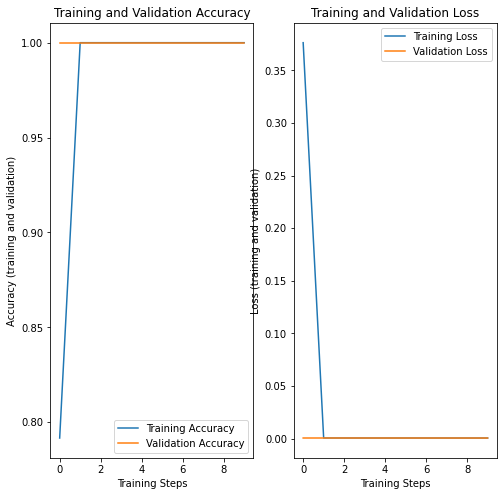

In [ ]:
import matplotlib.pylab as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:

# Import OpenCV
import cv2
# Utility
import itertools
import random
from collections import Counter
from glob import iglob

def load_image(filename):
    img = cv2.imread(os.path.join(r"./malignant/", filename))
    print(validation_dir)
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}
    


SOURCE: class: train/normal, file: train/normal/24.png
/root/.keras/datasets/DDSM/validation
1/1 [==============================] - 2s 2s/step
PREDICTED: class: Begnin, confidence: 0.382906


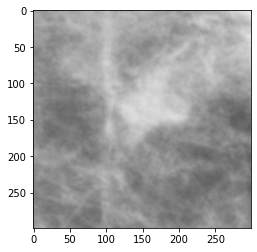

<Figure size 432x288 with 0 Axes>

SOURCE: class: train/malignant, file: train/malignant/9217.png
/root/.keras/datasets/DDSM/validation
1/1 [==============================] - 2s 2s/step
PREDICTED: class: Begnin, confidence: 0.400959


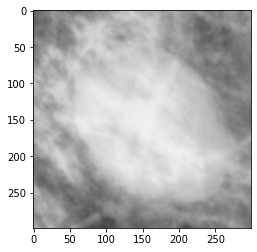

SOURCE: class: train/malignant, file: train/malignant/9272.png
/root/.keras/datasets/DDSM/validation
1/1 [==============================] - 1s 1s/step
PREDICTED: class: Begnin, confidence: 0.440317


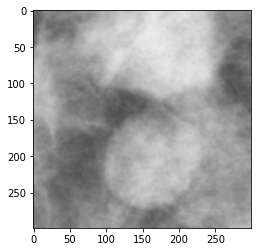

<Figure size 432x288 with 0 Axes>

SOURCE: class: train/begnin, file: train/begnin/10121.png
/root/.keras/datasets/DDSM/validation
1/1 [==============================] - 1s 764ms/step
PREDICTED: class: Begnin, confidence: 0.403779


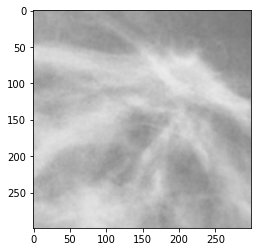

<Figure size 432x288 with 0 Axes>

SOURCE: class: train/normal, file: train/normal/50.png
/root/.keras/datasets/DDSM/validation
1/1 [==============================] - 1s 623ms/step
PREDICTED: class: Begnin, confidence: 0.409399


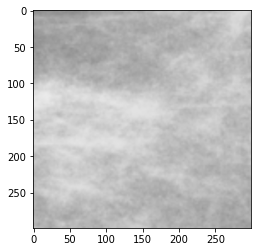

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [4]:

import time
t = time.time()

export_path = "/content/sample_data".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

NameError: ignored